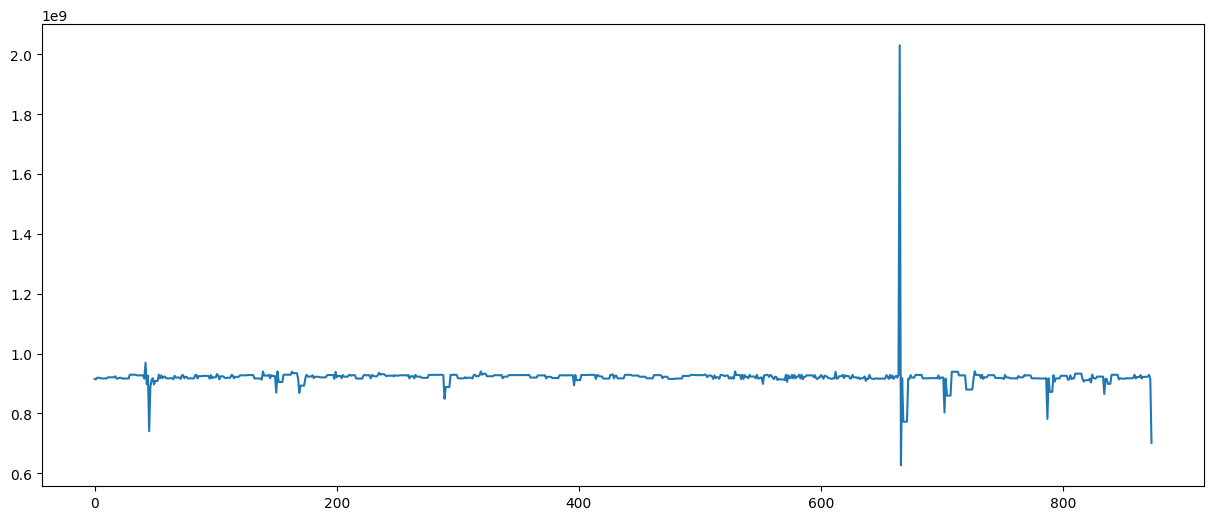

Epoch 1/150
18/18 [==============================] - 3s 38ms/step - loss: 0.1274 - val_loss: 0.0039
Epoch 2/150
18/18 [==============================] - 0s 17ms/step - loss: 0.0177 - val_loss: 0.0040
Epoch 3/150
18/18 [==============================] - 0s 16ms/step - loss: 0.0115 - val_loss: 0.0010
Epoch 4/150
18/18 [==============================] - 0s 27ms/step - loss: 0.0097 - val_loss: 7.2968e-04
Epoch 5/150
18/18 [==============================] - 0s 18ms/step - loss: 0.0084 - val_loss: 7.7278e-04
Epoch 6/150
18/18 [==============================] - 0s 18ms/step - loss: 0.0082 - val_loss: 7.9975e-04
Epoch 7/150
18/18 [==============================] - 0s 21ms/step - loss: 0.0073 - val_loss: 7.4388e-04
Epoch 8/150
18/18 [==============================] - 0s 18ms/step - loss: 0.0076 - val_loss: 7.1382e-04
Epoch 9/150
18/18 [==============================] - 0s 19ms/step - loss: 0.0067 - val_loss: 7.9139e-04
Epoch 10/150
18/18 [==============================] - 0s 19ms/step - loss: 0

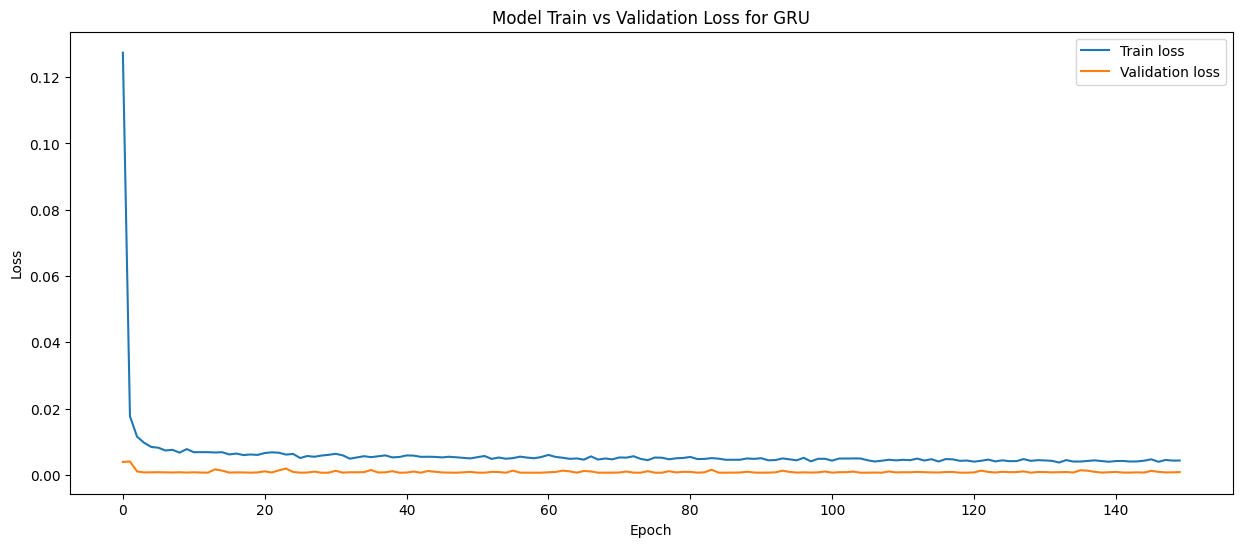

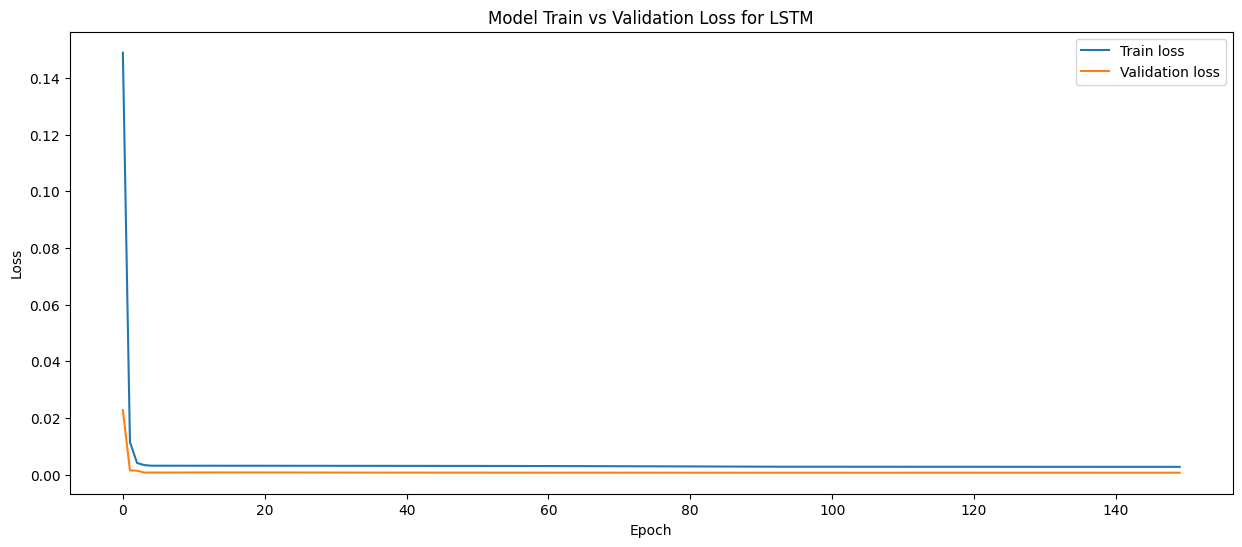

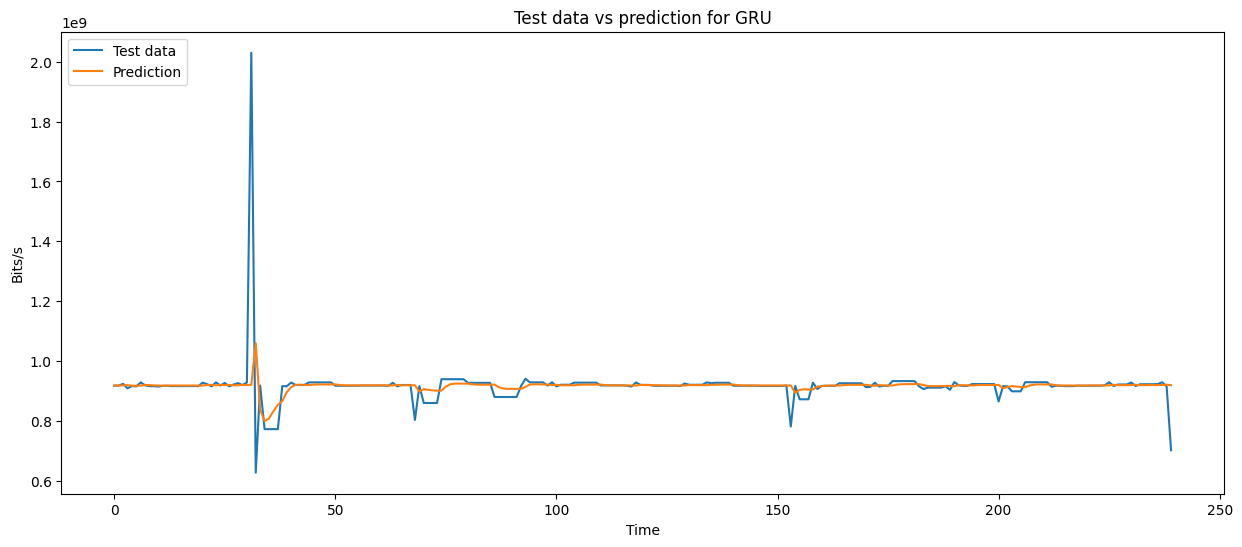

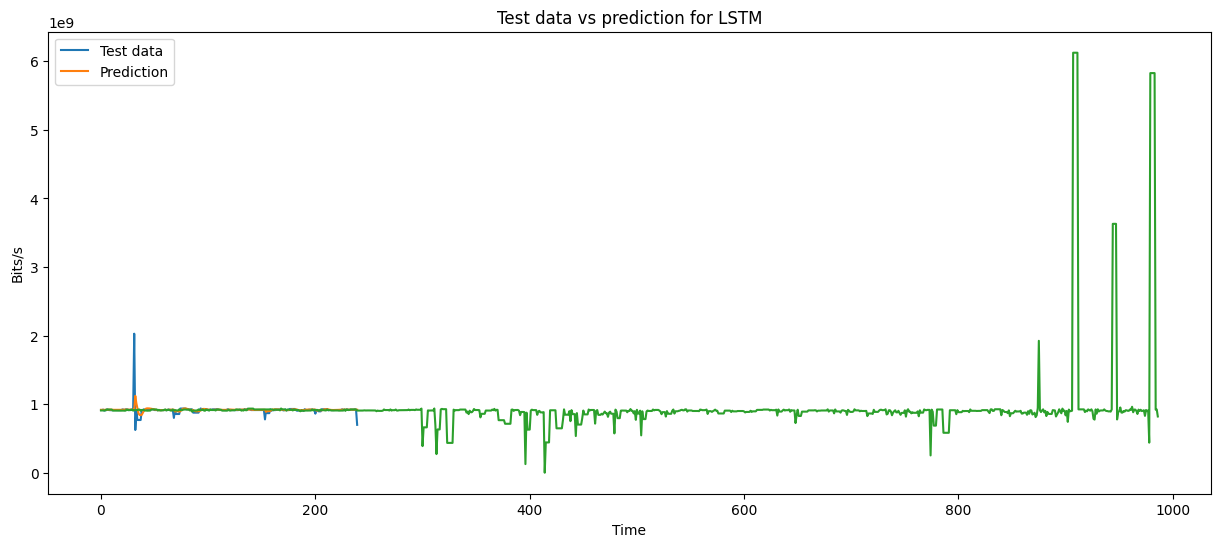

Epoch 1/150
22/22 [==============================] - 2s 31ms/step - loss: 0.2310 - val_loss: 0.0134
Epoch 2/150
22/22 [==============================] - 1s 24ms/step - loss: 0.0289 - val_loss: 0.0016
Epoch 3/150
22/22 [==============================] - 1s 25ms/step - loss: 0.0186 - val_loss: 0.0011
Epoch 4/150
22/22 [==============================] - 0s 17ms/step - loss: 0.0193 - val_loss: 0.0029
Epoch 5/150
22/22 [==============================] - 0s 17ms/step - loss: 0.0187 - val_loss: 0.0030
Epoch 6/150
22/22 [==============================] - 0s 19ms/step - loss: 0.0167 - val_loss: 0.0019
Epoch 7/150
22/22 [==============================] - 0s 19ms/step - loss: 0.0182 - val_loss: 0.0028
Epoch 8/150
22/22 [==============================] - 0s 15ms/step - loss: 0.0169 - val_loss: 0.0016
Epoch 9/150
22/22 [==============================] - 0s 18ms/step - loss: 0.0174 - val_loss: 6.8401e-04
Epoch 10/150
22/22 [==============================] - 0s 19ms/step - loss: 0.0168 - val_loss: 7.

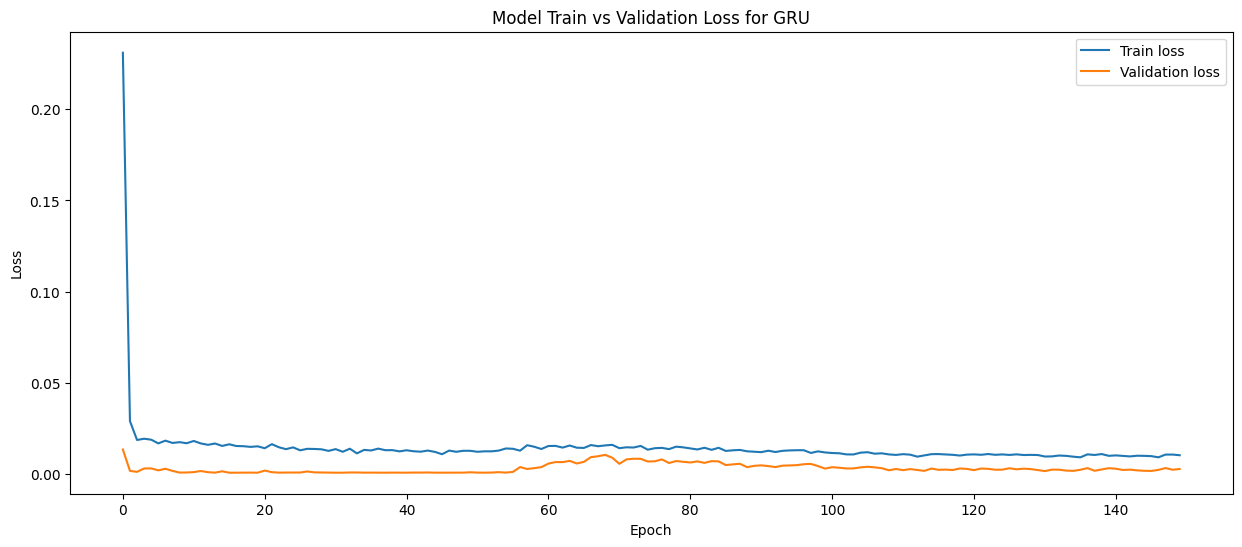

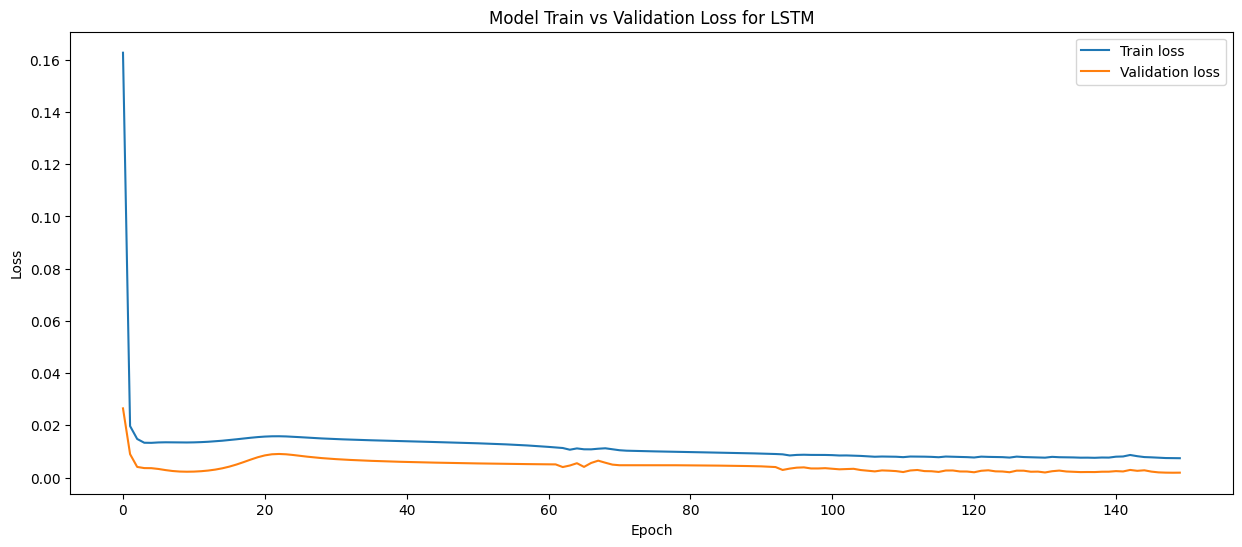

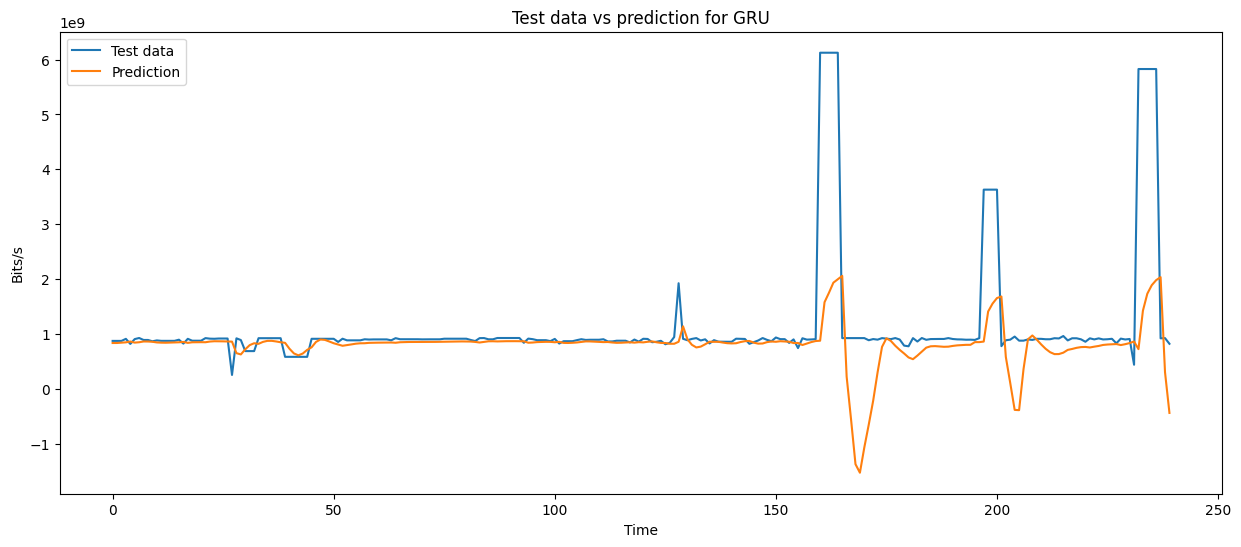

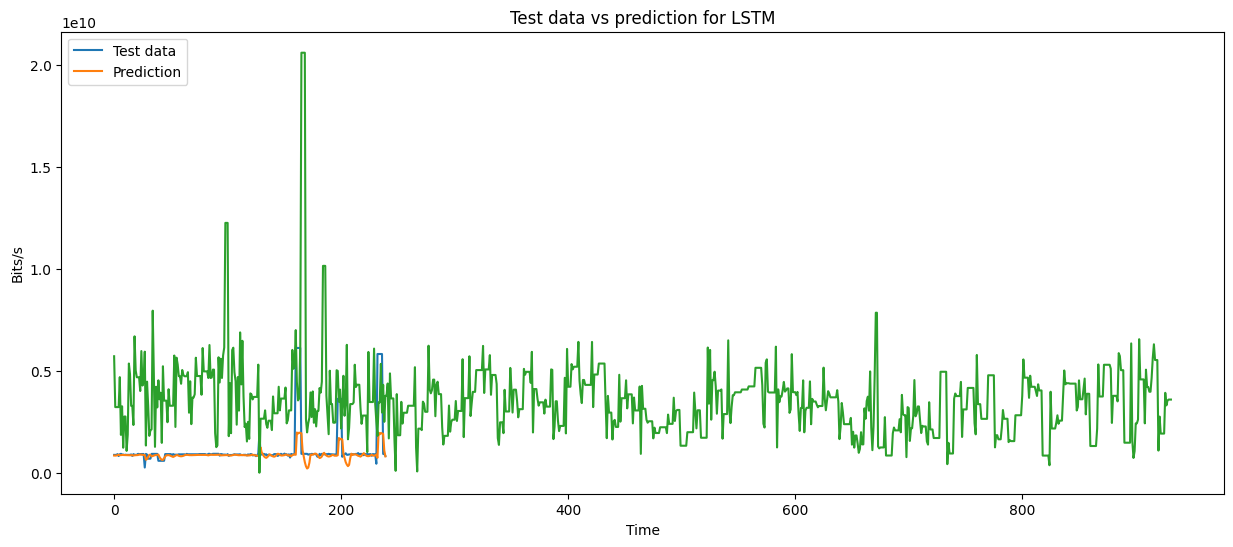

Epoch 1/150
20/20 [==============================] - 2s 32ms/step - loss: 0.0167 - val_loss: 0.0034
Epoch 2/150
20/20 [==============================] - 0s 20ms/step - loss: 0.0103 - val_loss: 0.0020
Epoch 3/150
20/20 [==============================] - 0s 20ms/step - loss: 0.0086 - val_loss: 0.0018
Epoch 4/150
20/20 [==============================] - 0s 24ms/step - loss: 0.0084 - val_loss: 0.0019
Epoch 5/150
20/20 [==============================] - 0s 17ms/step - loss: 0.0080 - val_loss: 0.0019
Epoch 6/150
20/20 [==============================] - 0s 20ms/step - loss: 0.0085 - val_loss: 0.0019
Epoch 7/150
20/20 [==============================] - 0s 23ms/step - loss: 0.0083 - val_loss: 0.0019
Epoch 8/150
20/20 [==============================] - 0s 20ms/step - loss: 0.0077 - val_loss: 0.0020
Epoch 9/150
20/20 [==============================] - 1s 28ms/step - loss: 0.0075 - val_loss: 0.0021
Epoch 10/150
20/20 [==============================] - 0s 23ms/step - loss: 0.0070 - val_loss: 0.0020

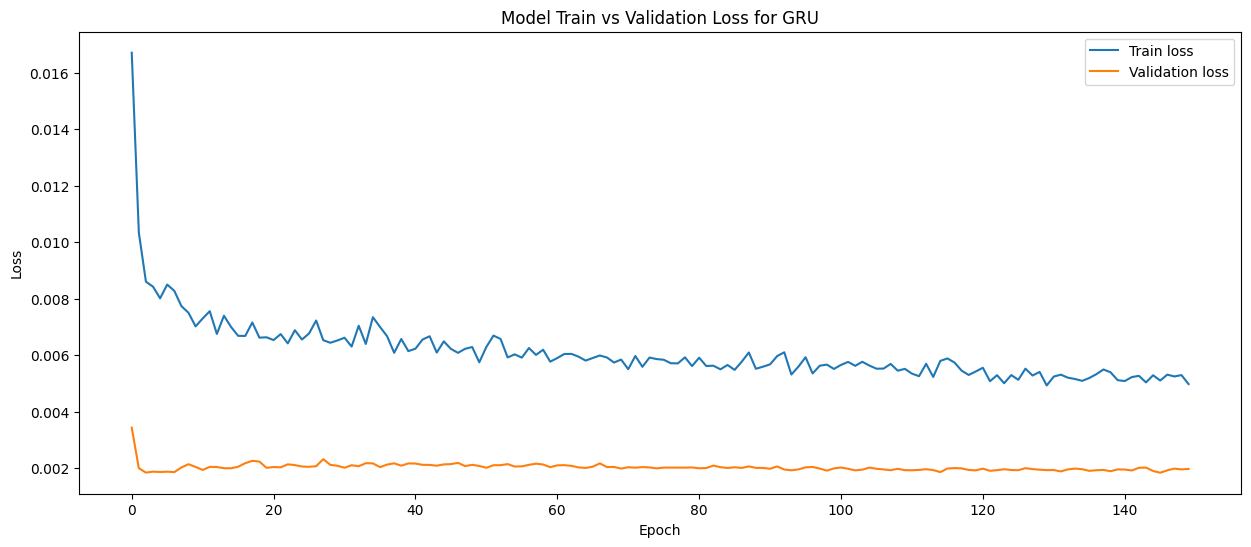

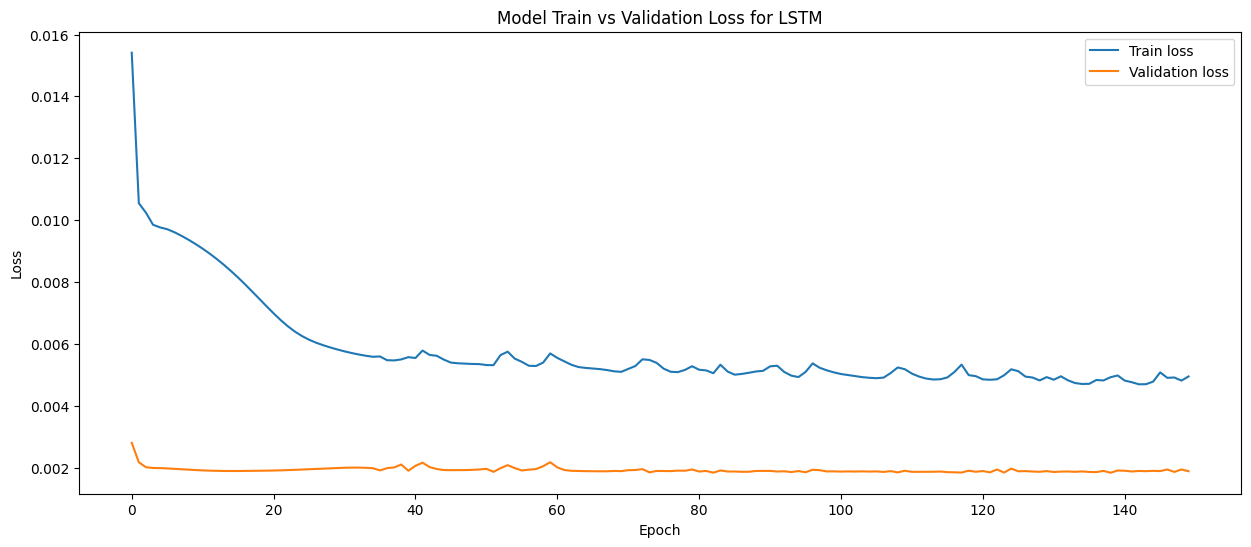

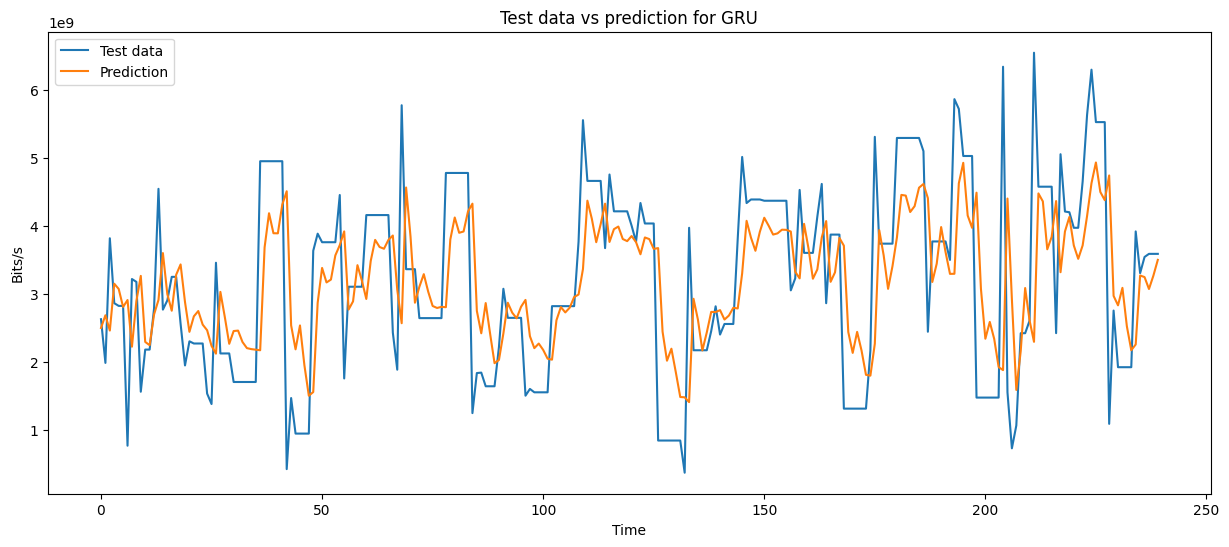

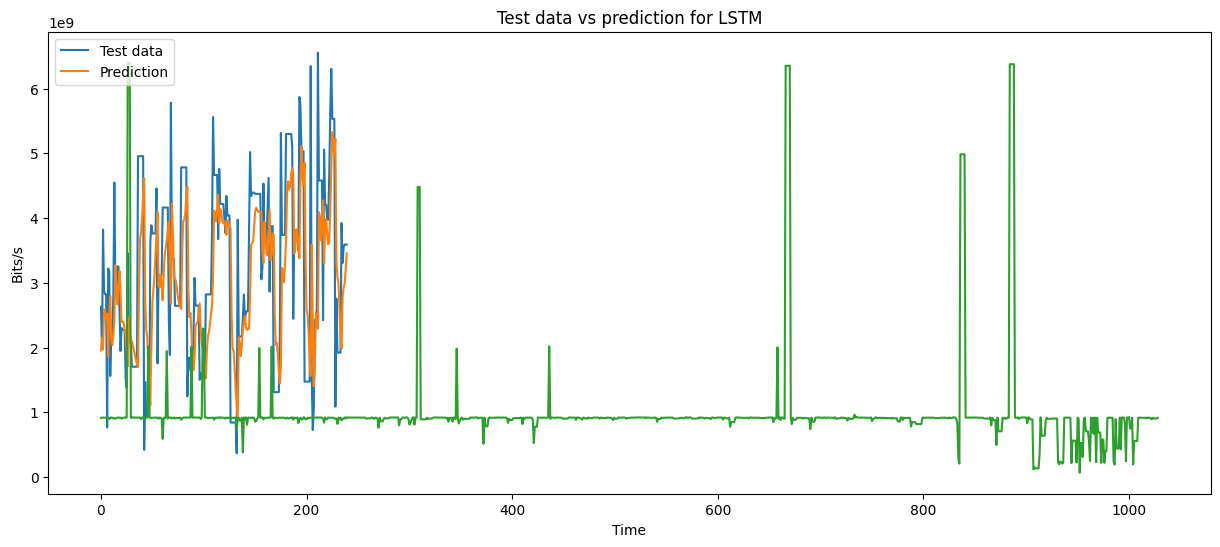

Epoch 1/150
23/23 [==============================] - 3s 35ms/step - loss: 0.0038 - val_loss: 0.0238
Epoch 2/150
23/23 [==============================] - 0s 21ms/step - loss: 0.0025 - val_loss: 0.0234
Epoch 3/150
23/23 [==============================] - 0s 22ms/step - loss: 0.0024 - val_loss: 0.0228
Epoch 4/150
23/23 [==============================] - 0s 21ms/step - loss: 0.0024 - val_loss: 0.0222
Epoch 5/150
23/23 [==============================] - 1s 26ms/step - loss: 0.0023 - val_loss: 0.0218
Epoch 6/150
23/23 [==============================] - 0s 16ms/step - loss: 0.0022 - val_loss: 0.0210
Epoch 7/150
23/23 [==============================] - 0s 15ms/step - loss: 0.0022 - val_loss: 0.0201
Epoch 8/150
23/23 [==============================] - 0s 16ms/step - loss: 0.0022 - val_loss: 0.0192
Epoch 9/150
23/23 [==============================] - 1s 24ms/step - loss: 0.0022 - val_loss: 0.0187
Epoch 10/150
23/23 [==============================] - 1s 25ms/step - loss: 0.0021 - val_loss: 0.0178

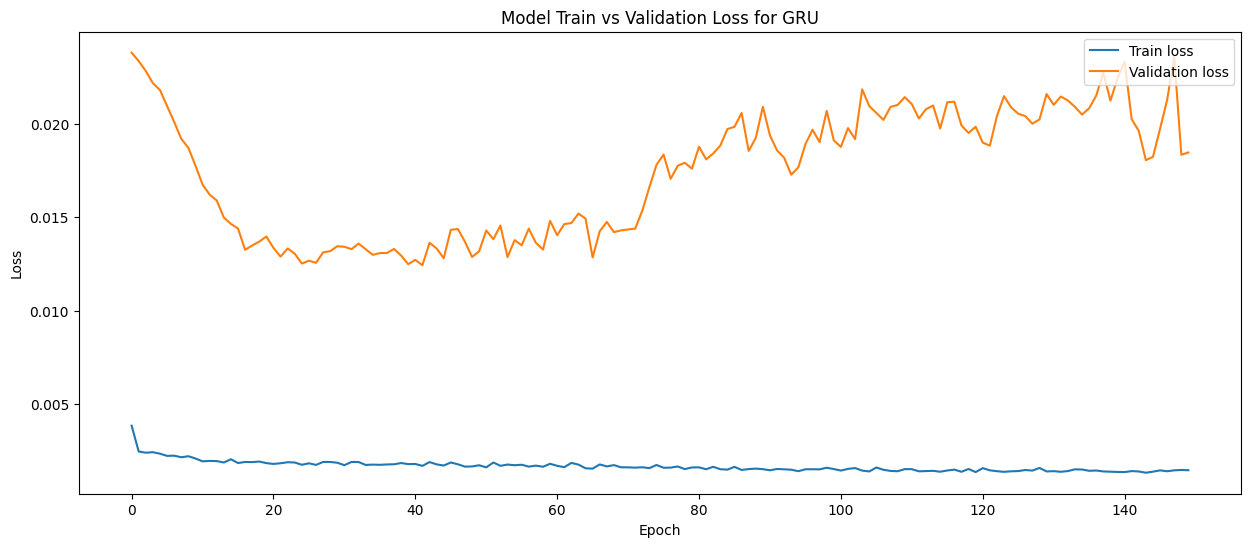

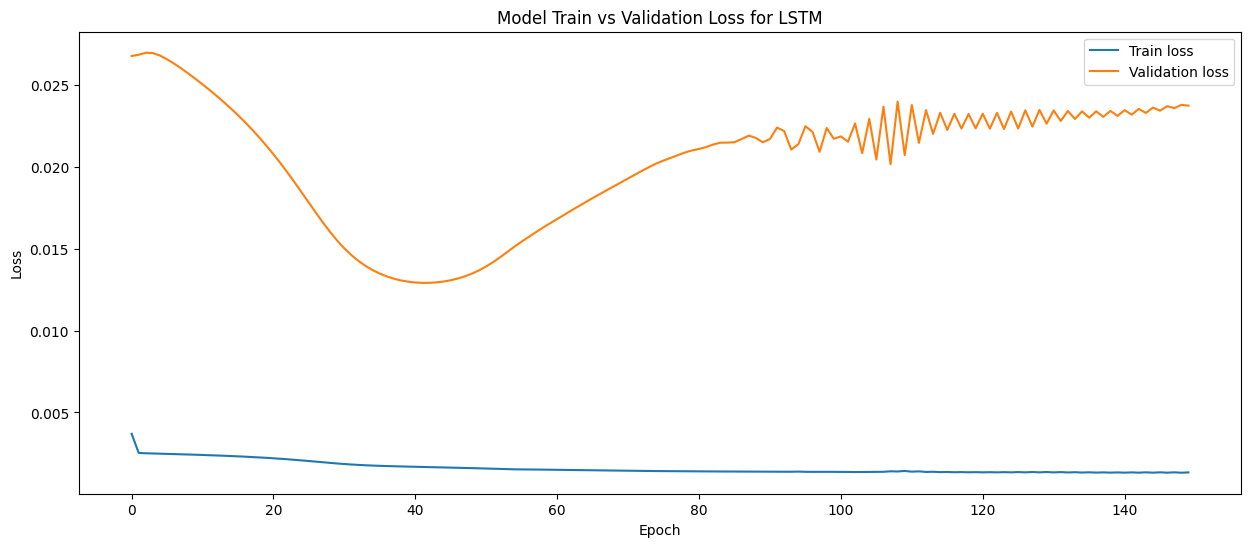

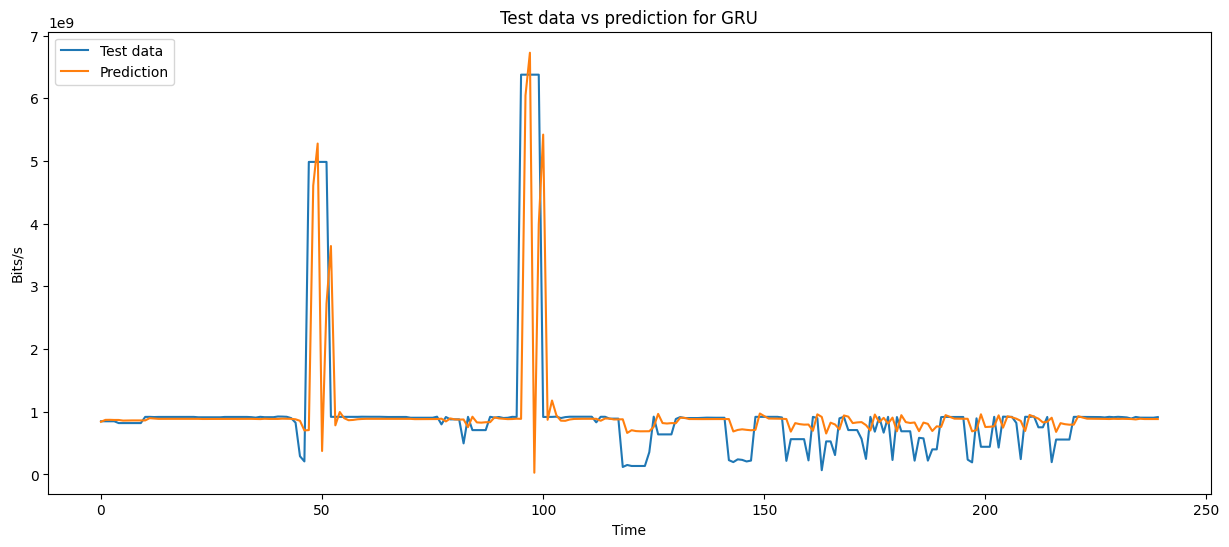

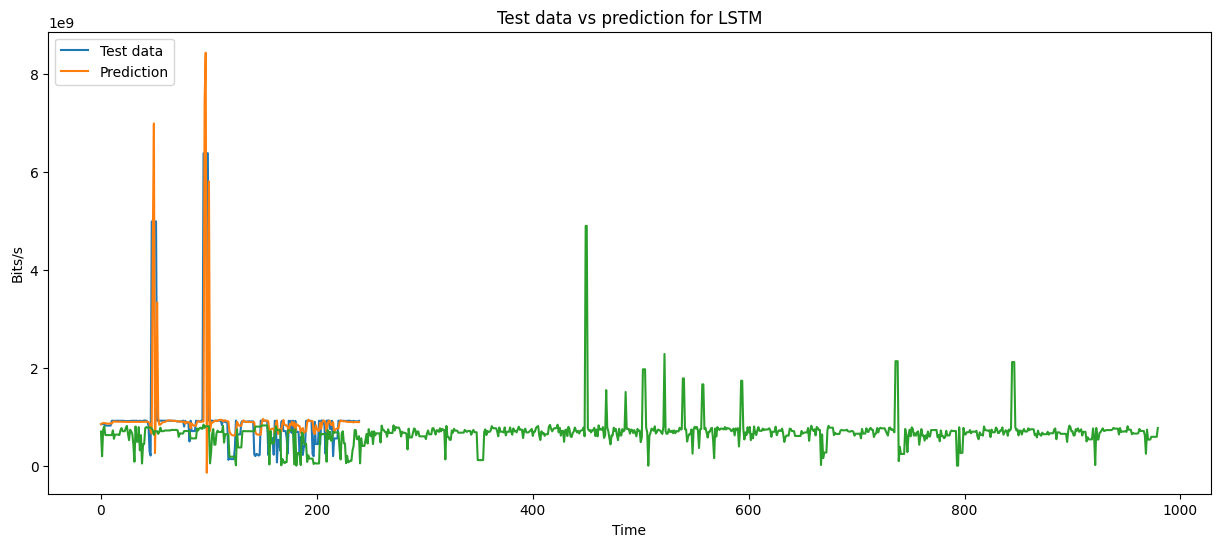

Epoch 1/150
21/21 [==============================] - 2s 33ms/step - loss: 0.0066 - val_loss: 0.0020
Epoch 2/150
21/21 [==============================] - 1s 30ms/step - loss: 0.0057 - val_loss: 0.0022
Epoch 3/150
21/21 [==============================] - 0s 24ms/step - loss: 0.0056 - val_loss: 0.0019
Epoch 4/150
21/21 [==============================] - 0s 20ms/step - loss: 0.0057 - val_loss: 0.0014
Epoch 5/150
21/21 [==============================] - 1s 26ms/step - loss: 0.0054 - val_loss: 0.0013
Epoch 6/150
21/21 [==============================] - 0s 23ms/step - loss: 0.0051 - val_loss: 0.0012
Epoch 7/150
21/21 [==============================] - 0s 21ms/step - loss: 0.0047 - val_loss: 0.0012
Epoch 8/150
21/21 [==============================] - 0s 15ms/step - loss: 0.0049 - val_loss: 0.0012
Epoch 9/150
21/21 [==============================] - 0s 21ms/step - loss: 0.0046 - val_loss: 0.0012
Epoch 10/150
21/21 [==============================] - 0s 23ms/step - loss: 0.0051 - val_loss: 0.0011

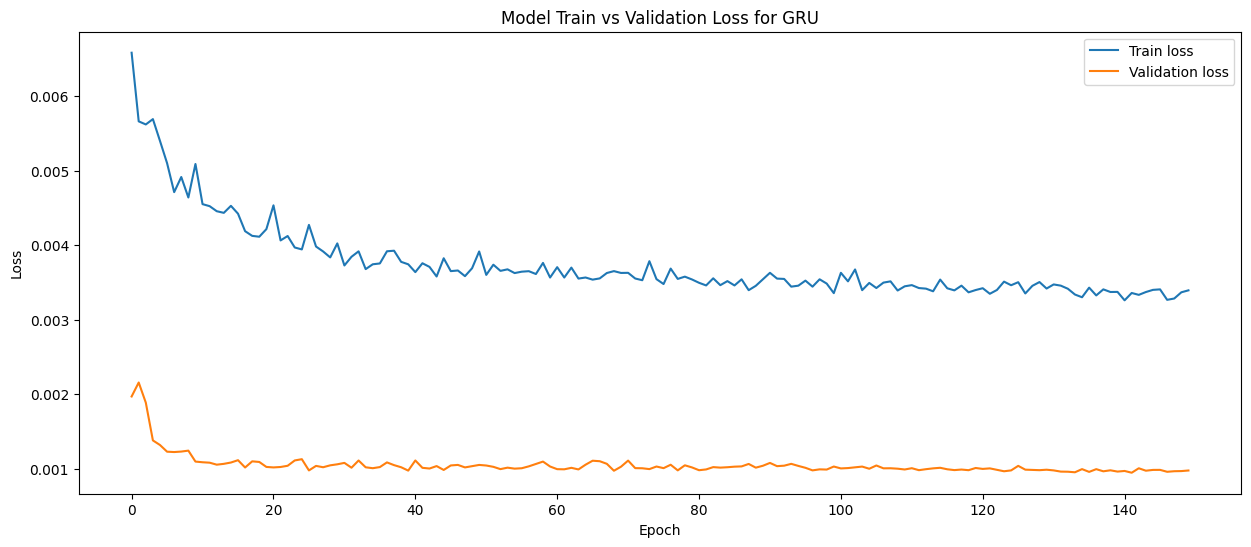

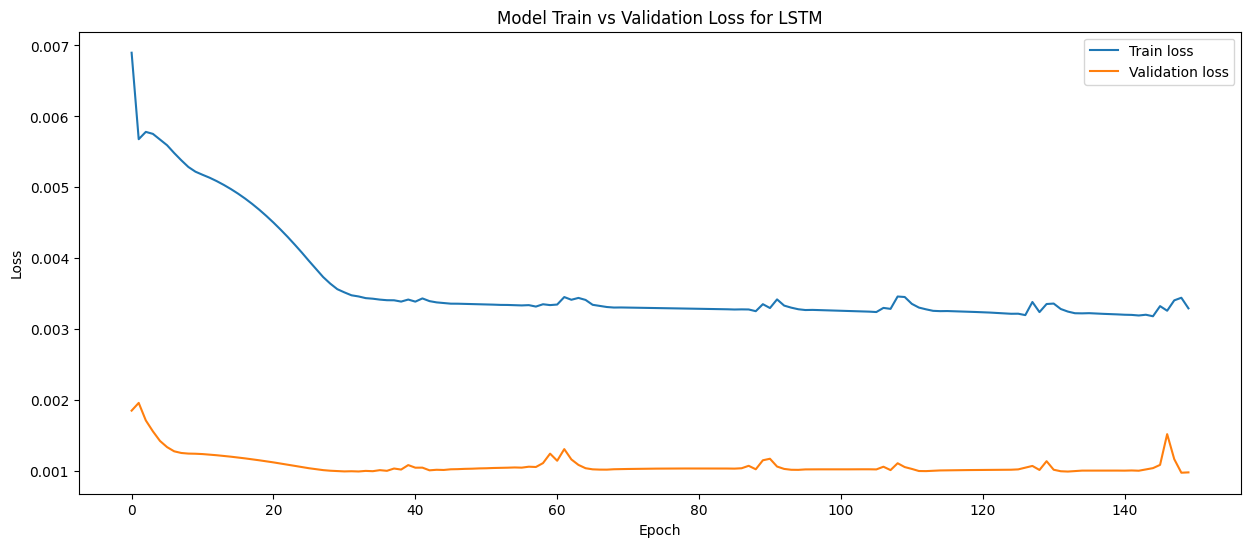

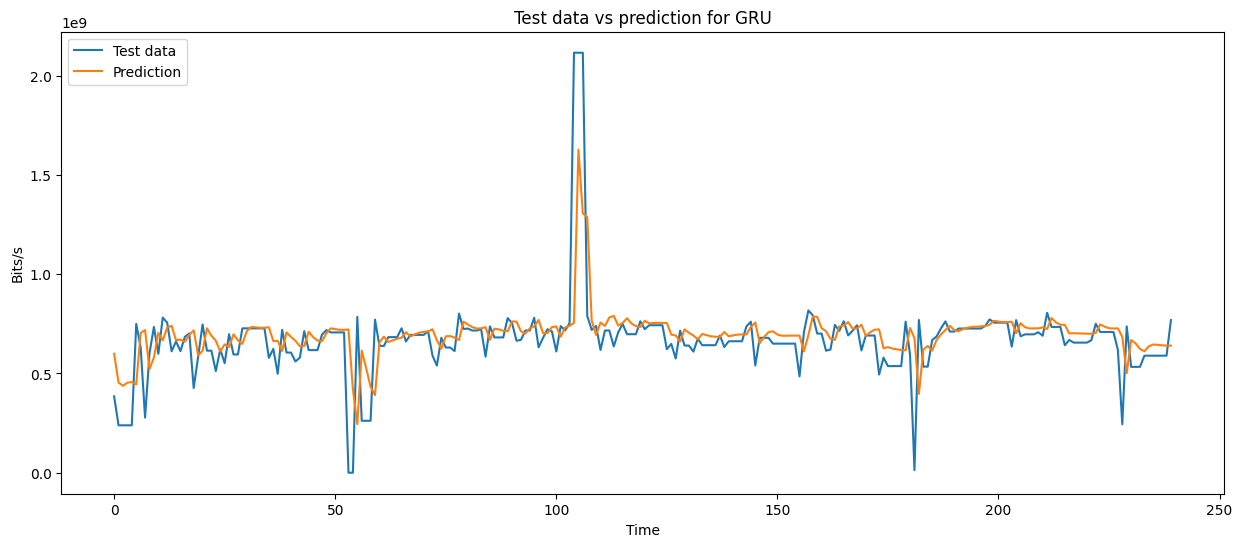

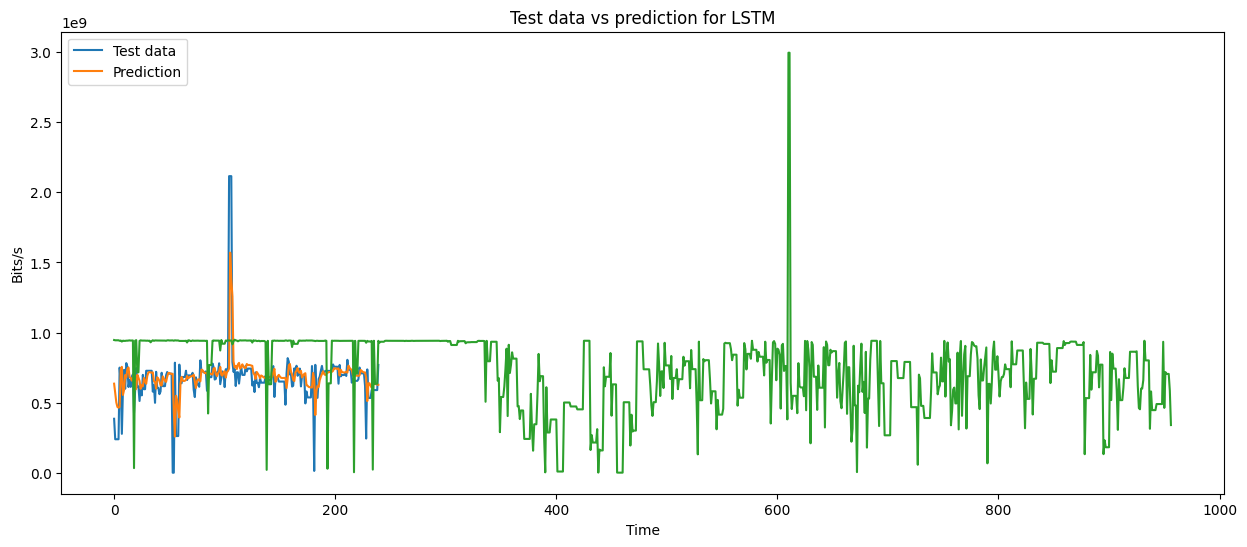

Epoch 1/150
21/21 [==============================] - 2s 32ms/step - loss: 0.0176 - val_loss: 0.0184
Epoch 2/150
21/21 [==============================] - 0s 15ms/step - loss: 0.0082 - val_loss: 0.0131
Epoch 3/150
21/21 [==============================] - 0s 21ms/step - loss: 0.0048 - val_loss: 0.0134
Epoch 4/150
21/21 [==============================] - 0s 19ms/step - loss: 0.0042 - val_loss: 0.0137
Epoch 5/150
21/21 [==============================] - 0s 21ms/step - loss: 0.0042 - val_loss: 0.0142
Epoch 6/150
21/21 [==============================] - 0s 16ms/step - loss: 0.0044 - val_loss: 0.0142
Epoch 7/150
21/21 [==============================] - 0s 17ms/step - loss: 0.0039 - val_loss: 0.0145
Epoch 8/150
21/21 [==============================] - 1s 26ms/step - loss: 0.0039 - val_loss: 0.0144
Epoch 9/150
21/21 [==============================] - 0s 20ms/step - loss: 0.0039 - val_loss: 0.0146
Epoch 10/150
21/21 [==============================] - 1s 24ms/step - loss: 0.0041 - val_loss: 0.0146

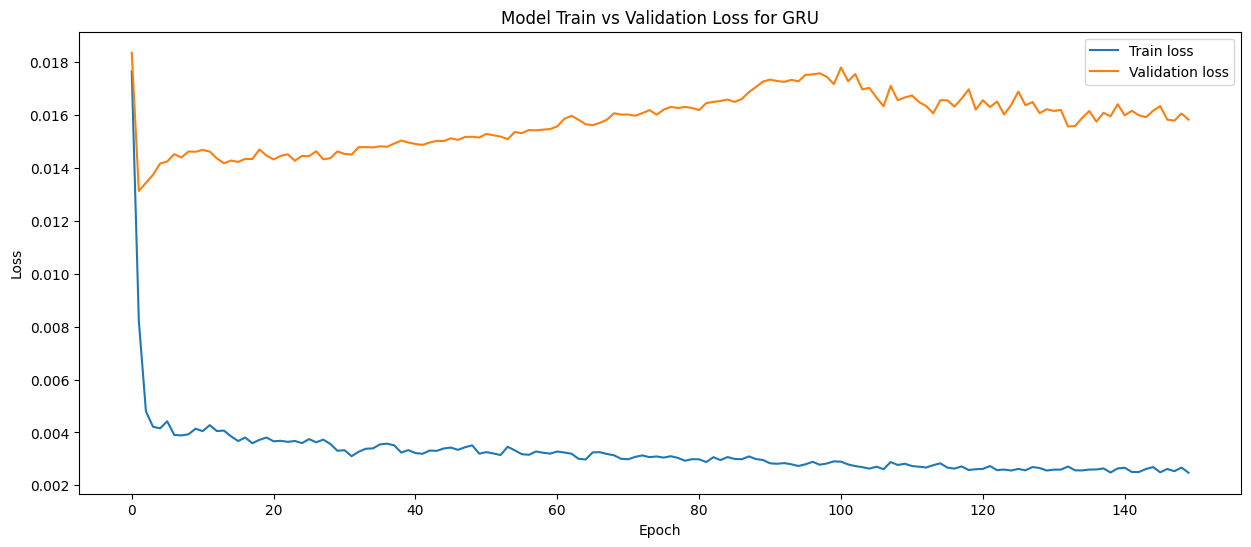

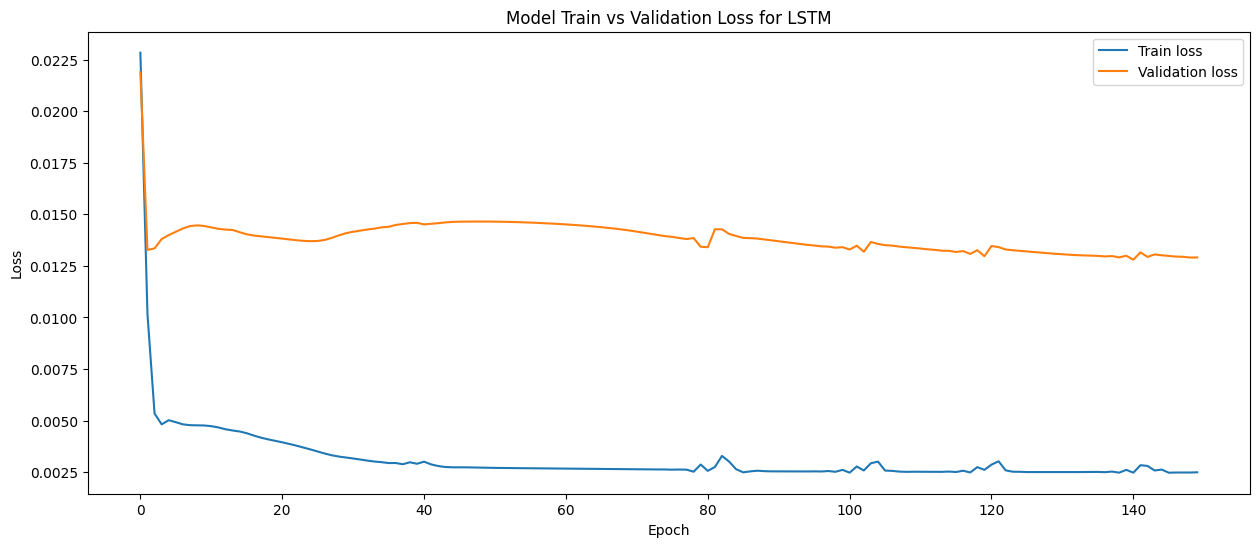

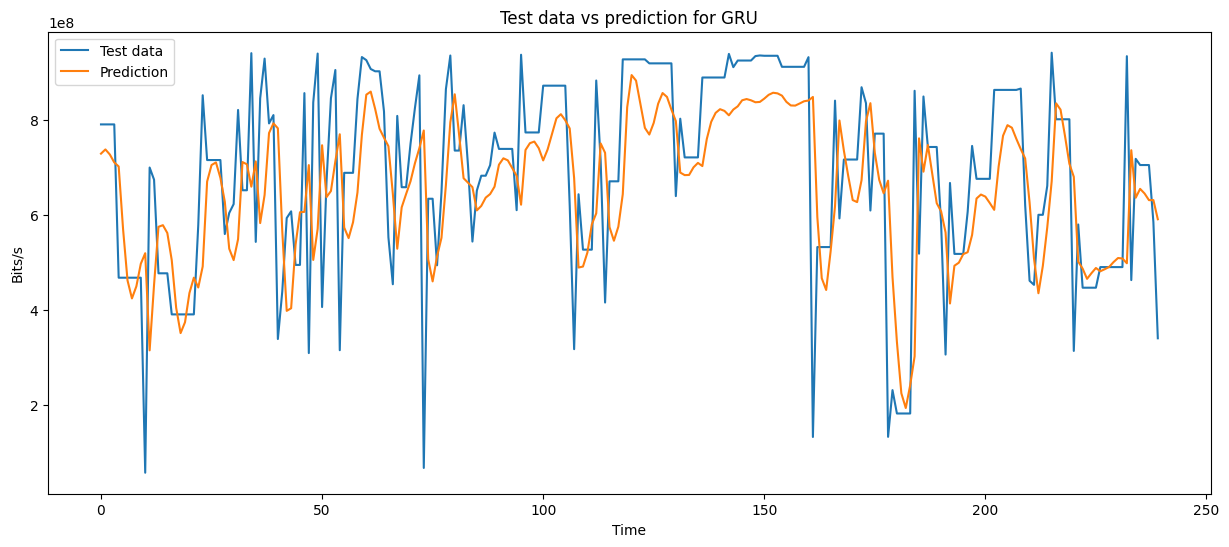

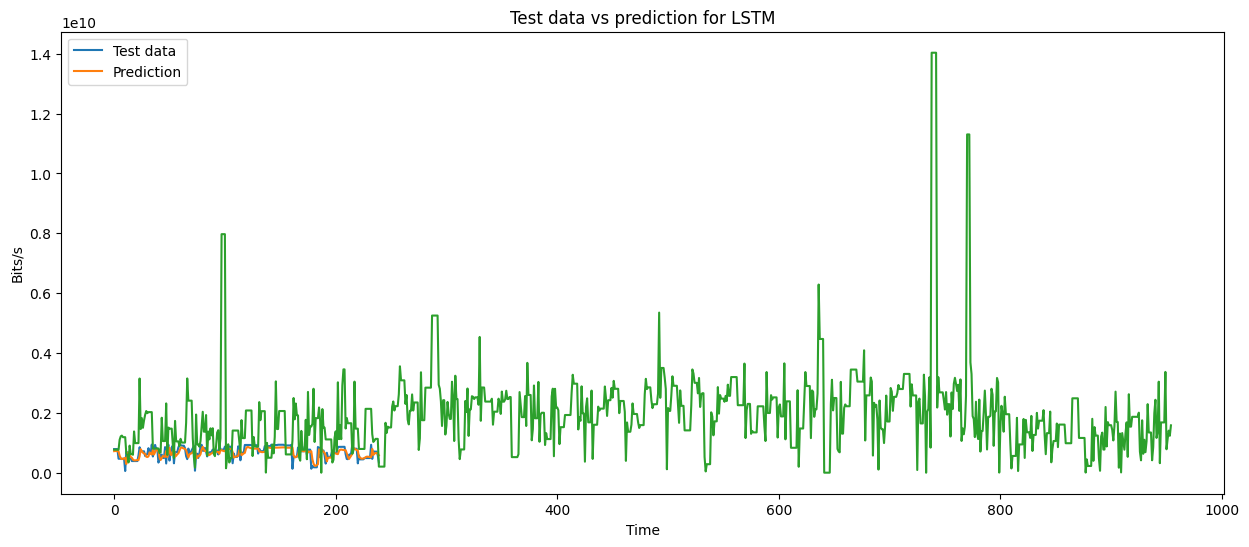

Epoch 1/150
21/21 [==============================] - 3s 33ms/step - loss: 0.0182 - val_loss: 0.0146
Epoch 2/150
21/21 [==============================] - 0s 23ms/step - loss: 0.0137 - val_loss: 0.0135
Epoch 3/150
21/21 [==============================] - 0s 16ms/step - loss: 0.0139 - val_loss: 0.0136
Epoch 4/150
21/21 [==============================] - 0s 16ms/step - loss: 0.0132 - val_loss: 0.0132
Epoch 5/150
21/21 [==============================] - 0s 21ms/step - loss: 0.0132 - val_loss: 0.0129
Epoch 6/150
21/21 [==============================] - 0s 17ms/step - loss: 0.0122 - val_loss: 0.0125
Epoch 7/150
21/21 [==============================] - 0s 21ms/step - loss: 0.0118 - val_loss: 0.0119
Epoch 8/150
21/21 [==============================] - 0s 20ms/step - loss: 0.0116 - val_loss: 0.0119
Epoch 9/150
21/21 [==============================] - 0s 16ms/step - loss: 0.0111 - val_loss: 0.0119
Epoch 10/150
21/21 [==============================] - 0s 15ms/step - loss: 0.0110 - val_loss: 0.0118

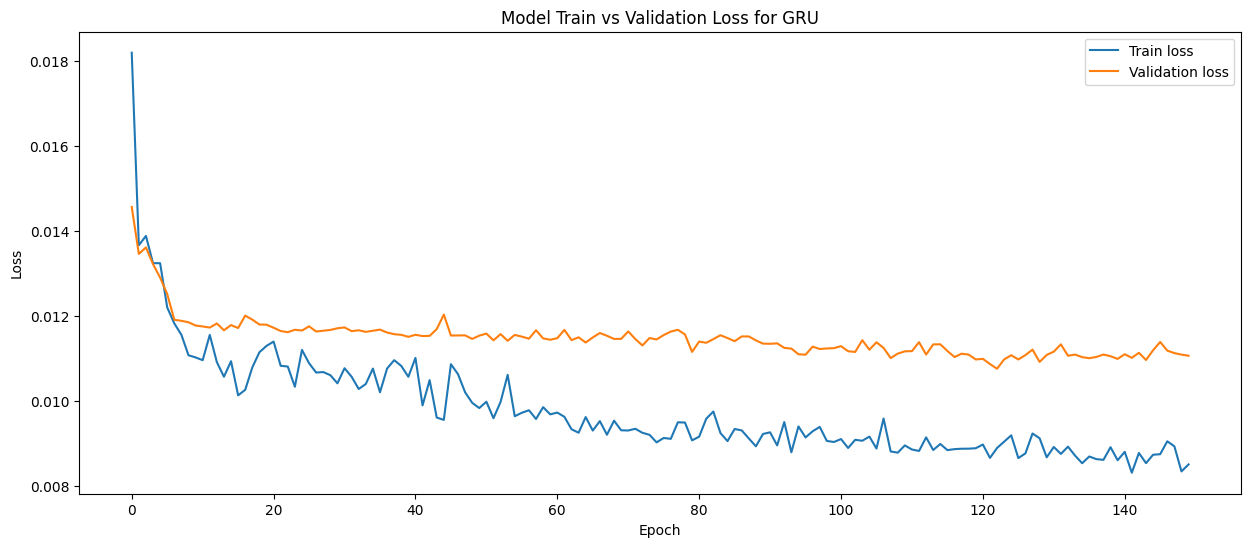

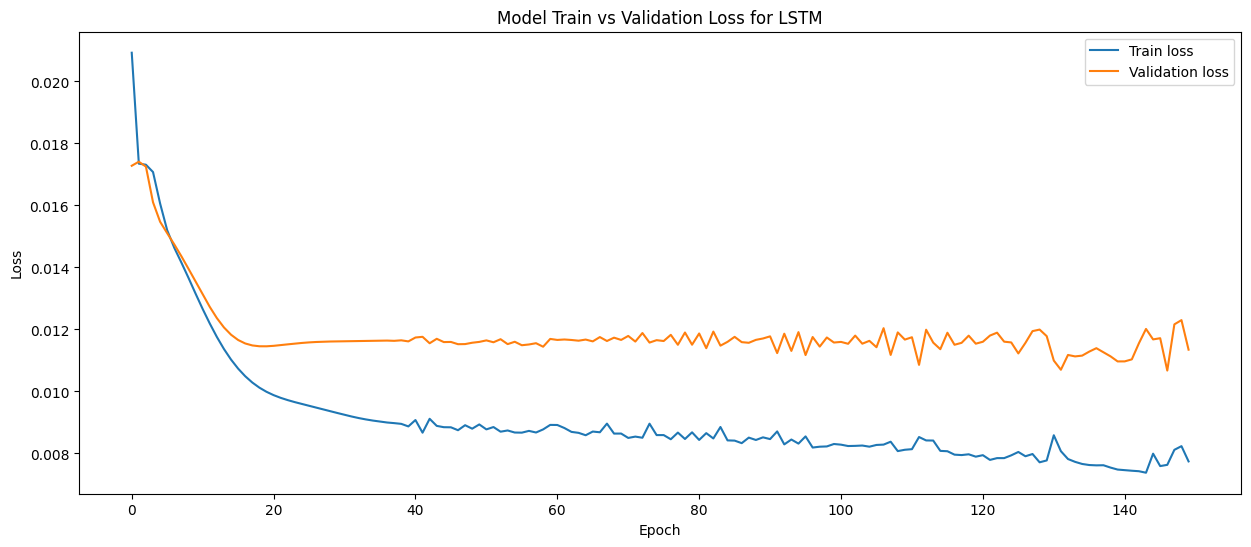

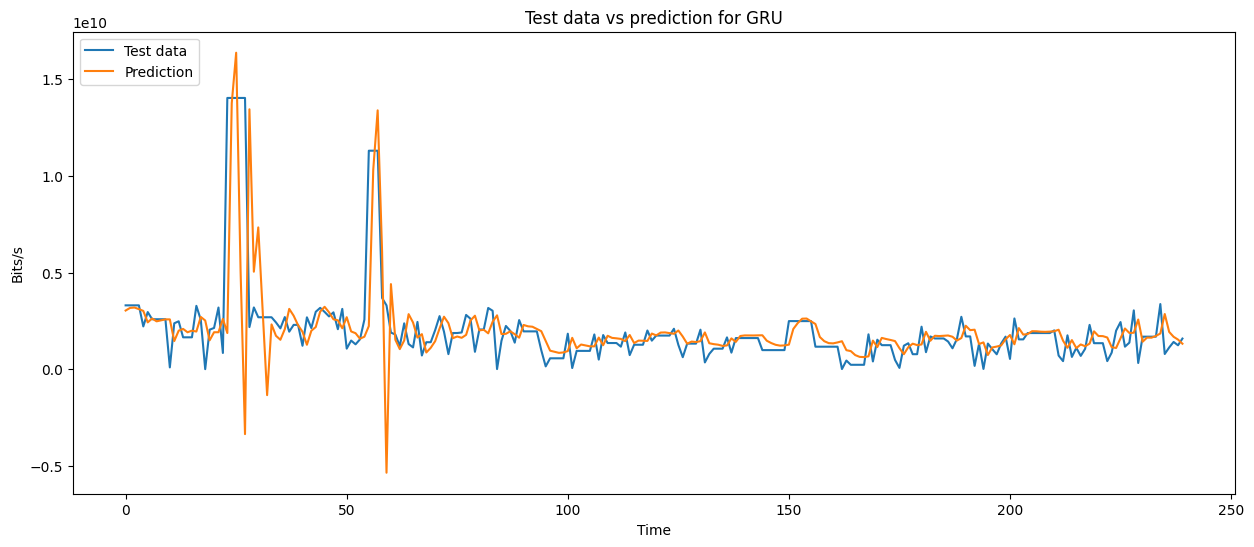

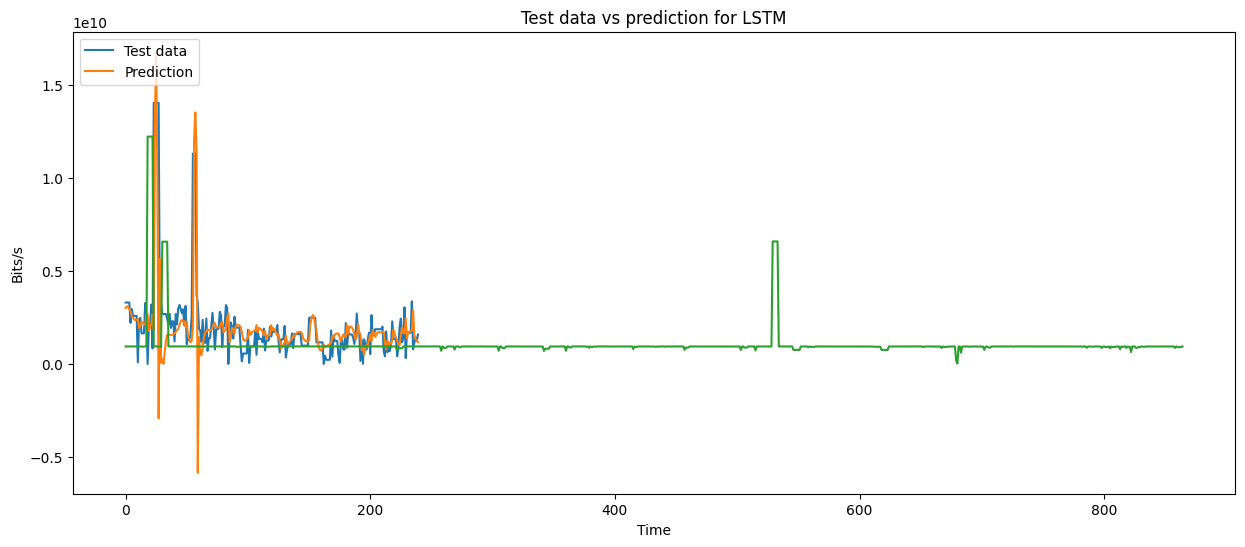

Epoch 1/150
18/18 [==============================] - 2s 38ms/step - loss: 0.0032 - val_loss: 0.0088
Epoch 2/150
18/18 [==============================] - 0s 21ms/step - loss: 0.0021 - val_loss: 0.0085
Epoch 3/150
18/18 [==============================] - 0s 13ms/step - loss: 0.0020 - val_loss: 0.0082
Epoch 4/150
18/18 [==============================] - 0s 15ms/step - loss: 0.0020 - val_loss: 0.0079
Epoch 5/150
18/18 [==============================] - 0s 20ms/step - loss: 0.0016 - val_loss: 0.0080
Epoch 6/150
18/18 [==============================] - 0s 19ms/step - loss: 0.0014 - val_loss: 0.0075
Epoch 7/150
18/18 [==============================] - 0s 19ms/step - loss: 0.0013 - val_loss: 0.0079
Epoch 8/150
18/18 [==============================] - 0s 15ms/step - loss: 0.0014 - val_loss: 0.0075
Epoch 9/150
18/18 [==============================] - 0s 17ms/step - loss: 0.0014 - val_loss: 0.0071
Epoch 10/150
18/18 [==============================] - 0s 21ms/step - loss: 0.0010 - val_loss: 0.0069

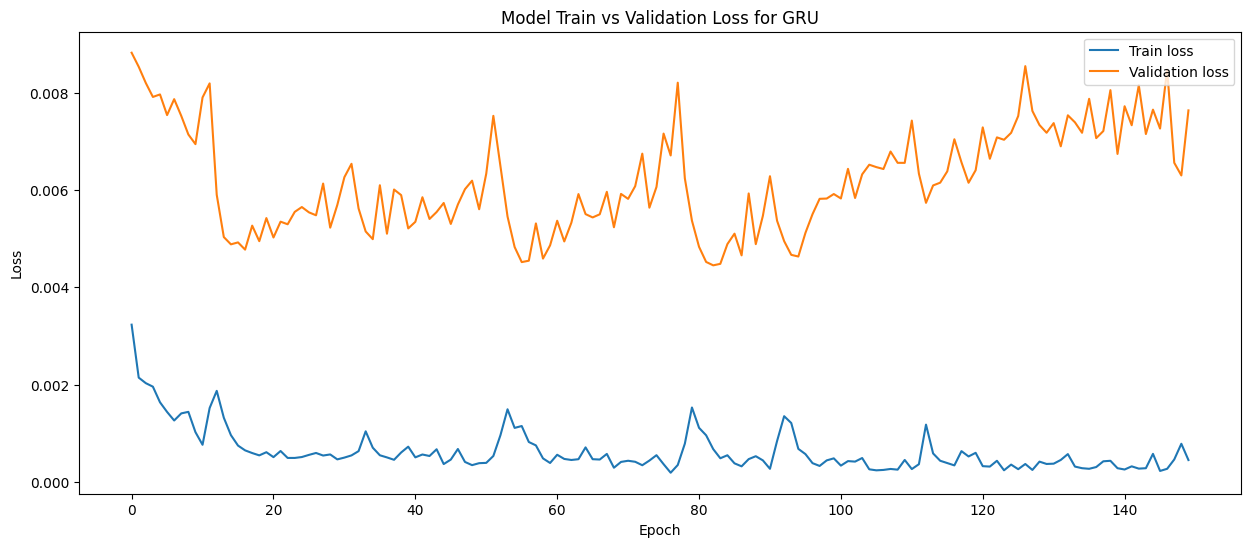

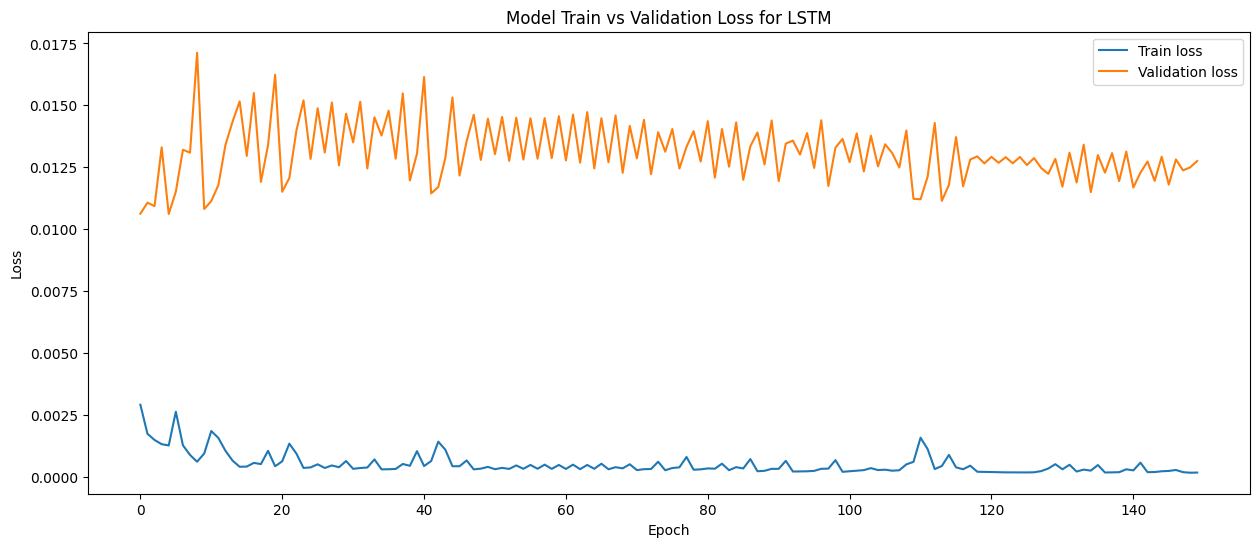

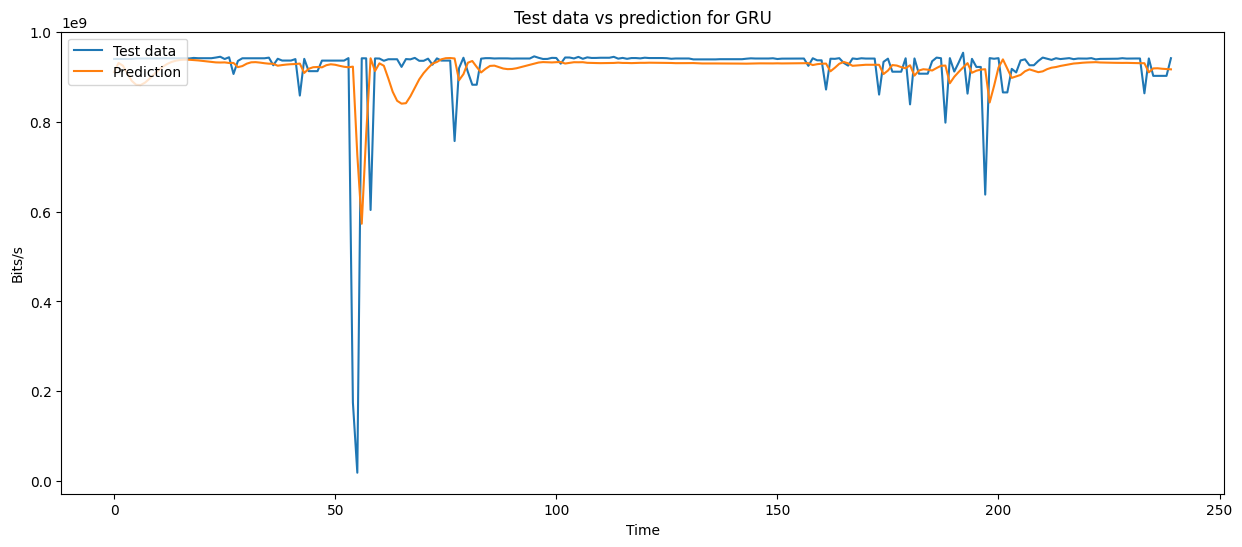

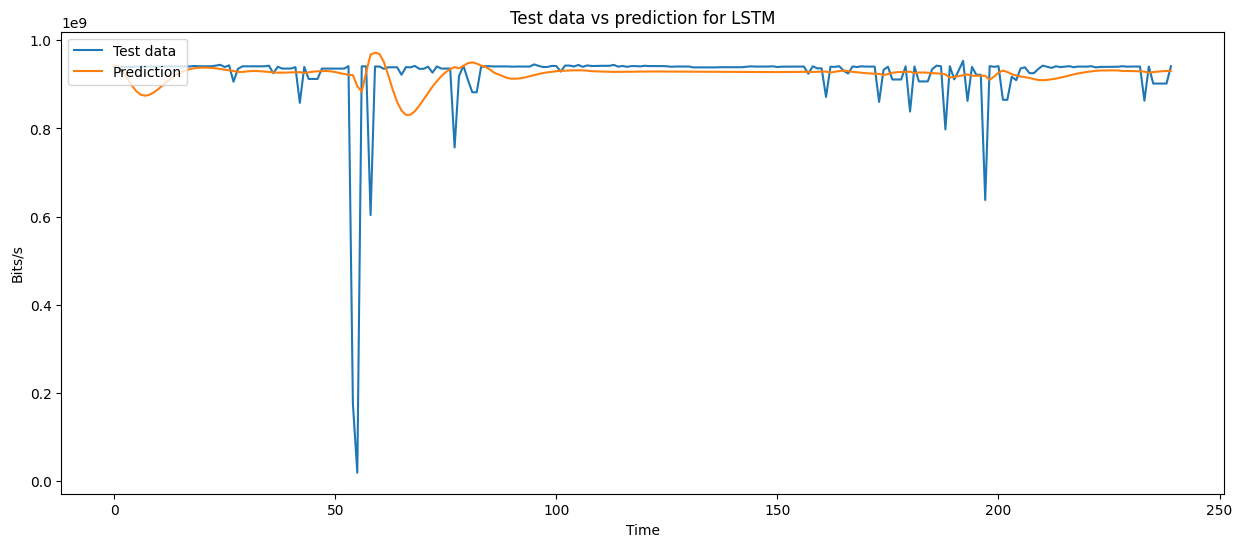

In [24]:

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from os import path, listdir
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
%matplotlib inline
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU

from matplotlib.pyplot import figure

figure(figsize = (15, 6), dpi = 100)

# Create input dataset
# Th input shape should be [samples, time steps, features]
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
        
    return np.array(Xs), np.array(ys)

# Create GRU model
def create_gru(units):
    model = Sequential()
    
    # Input layer 
    model.add(GRU(units = units, return_sequences = True, input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    
    # Hidden layer
    model.add(GRU(units = units))                 
    model.add(Dropout(0.2))
    model.add(Dense(1))
    
    #Compile model
    model.compile(optimizer='adam',loss='mse')
   
    return model

# Create LSTM model
def create_lstm(units):
    model = Sequential()
    
    # Input layer
    model.add(LSTM(units = units, return_sequences = True, input_shape = [X_train.shape[1], X_train.shape[2]]))
    
    # Hidden layer
    model.add(LSTM(units = units))
    model.add(Dense(1))
    
    #Compile model
    model.compile(optimizer ='adam',loss ='mse')
    
    return model

def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
    history = model.fit(X_train, y_train, epochs = 150, validation_split = 0.2, batch_size = 26, shuffle = False)
    return history

# Plot train loss and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (15, 6), dpi=100)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction

# Plot test data vs prediction
def plot_future(prediction, model_name, y_test, type, link):
    
    plt.figure(figsize=(15, 6), dpi=100)
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction), label='Prediction')
    
    dict_to_dataframe_prediction = {
        "range_future": np.arange(range_future),
        f"prediction{model_name}": np.array(prediction.squeeze())
    }

    dataframe_prediction = pd.DataFrame(dict_to_dataframe_prediction)
    dataframe_prediction.to_csv(f"prediction_plot_{type}_{link}_{model_name}.csv", header=False, index=False)
    
    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time')
    plt.ylabel('Bits/s')

# Calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')

_path = '../datasets vazao/original'
for folder in listdir(path.join(_path)):
    path_folder = path.join(_path, folder)
    for file in listdir(path_folder):
        dataset = pd.read_csv(path.join(path_folder, file), usecols = [0], engine ='python')
        type = folder
        s = file.index("-")
        link = file[s-2:s+3].upper()
        tamanho = len(dataset.index) - 270
        plt.plot(dataset)
        plt.show()

        # Set random seed to get the same result after each time running the code
        tf.random.set_seed(7)

        # Split train data and test data
        train_size = tamanho

        # train_data = df.WC.loc[:train_size] -----> it gives a series
        # Do not forget use iloc to select a number of rows
        train_data = dataset[:train_size]
        test_data = dataset[train_size:]

        # Scale data
        # The input to scaler.fit -> array-like, sparse matrix, dataframe of shape (n_samples, n_features)
        scaler = MinMaxScaler().fit(train_data)

        train_scaled = scaler.transform(train_data)
        test_scaled = scaler.transform(test_data)

        X_train, y_train = create_dataset(train_scaled,30)
        X_test, y_test = create_dataset(test_scaled,30)
        
        model_gru = create_gru(64)
        model_lstm = create_lstm(64)
        
        history_gru = fit_model(model_gru)
        history_lstm = fit_model(model_lstm)

        # Transform data back to original data space
        y_test = scaler.inverse_transform(y_test)
        y_train = scaler.inverse_transform(y_train)

        prediction_gru = prediction(model_gru)
        prediction_lstm = prediction(model_lstm)

        plot_loss (history_gru, 'GRU')
        plot_loss (history_lstm, 'LSTM')


        plot_future(prediction_gru, 'GRU', y_test, type=type, link=link)
        plot_future(prediction_lstm, 'LSTM', y_test, type=type, link=link)


        evaluate_prediction(prediction_gru, y_test, 'GRU')
        evaluate_prediction(prediction_lstm, y_test, 'LSTM')
